In [58]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [59]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':256, 'width':256, 'channels':3}

In [60]:
# Create a Classifier class

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [61]:
# Create a MesoNet class using the Classifier

class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [62]:
# Instantiate a MesoNet model with pretrained weights
meso = Meso4()
meso.load('./weights/Meso4_DF.h5')

In [63]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/validation',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 7104 images belonging to 2 classes.


In [64]:
# Checking class assignment
generator.class_indices

{'df': 0, 'real': 1}

1/1 [==============================] - 0s 172ms/step
Predicted likelihood: 0.0232
Actual label: 0
1/1 [==============================] - 0s 77ms/step

Correct prediction: True


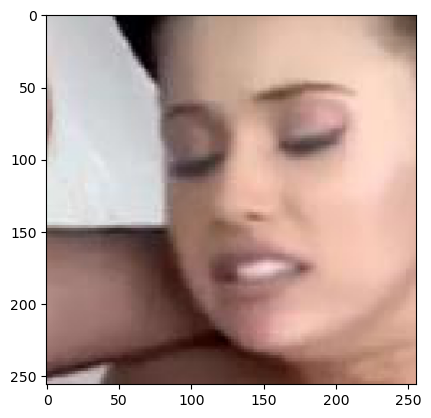

In [65]:
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [66]:
# Assuming you have loaded your 'meso' model and 'generator' as defined in your code

# Evaluate the model on the entire dataset
num_samples = generator.samples
batch_size = generator.batch_size

correct_predictions = 0

# Iterate through the dataset in batches and calculate correct predictions
for _ in range(num_samples // batch_size):
    X_batch, y_batch = generator.next()
    predicted_prob = meso.model.predict(X_batch, verbose=0)[0][0]
    predicted_label = round(predicted_prob)
    actual_label = int(y_batch[0])
    correct_predictions += (predicted_label == actual_label)

# Calculate accuracy
accuracy = correct_predictions / (num_samples // batch_size)

print(f"Model Accuracy: {accuracy:.2%}")

Model Accuracy: 88.82%


In [26]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [27]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [28]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.model.predict(X, verbose=0)[0][0]  
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")


0  predictions completed.
1000  predictions completed.
2000  predictions completed.
3000  predictions completed.
4000  predictions completed.
5000  predictions completed.
6000  predictions completed.
7000  predictions completed.
All 7104 predictions completed


In [12]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

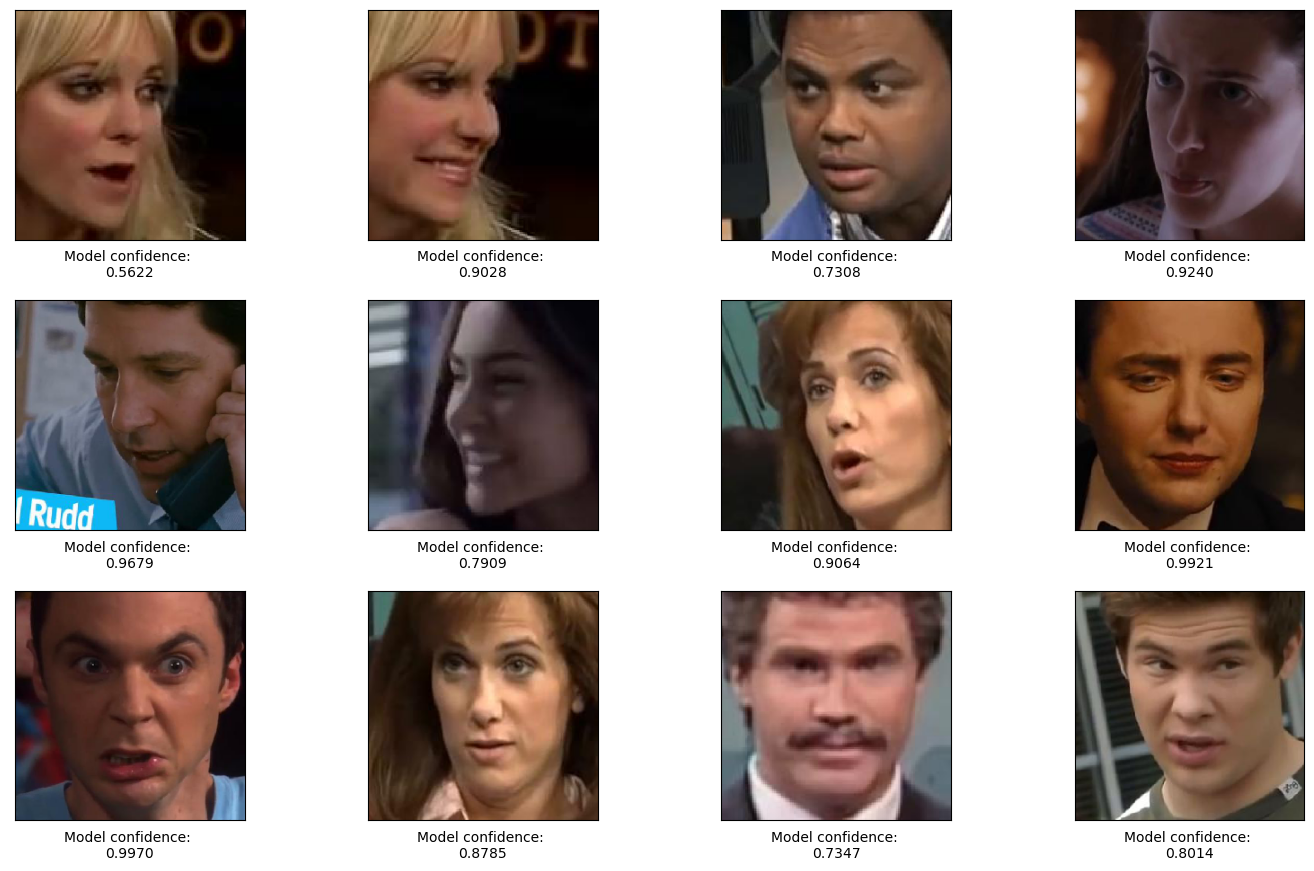

In [29]:
plotter(correct_real, correct_real_pred)

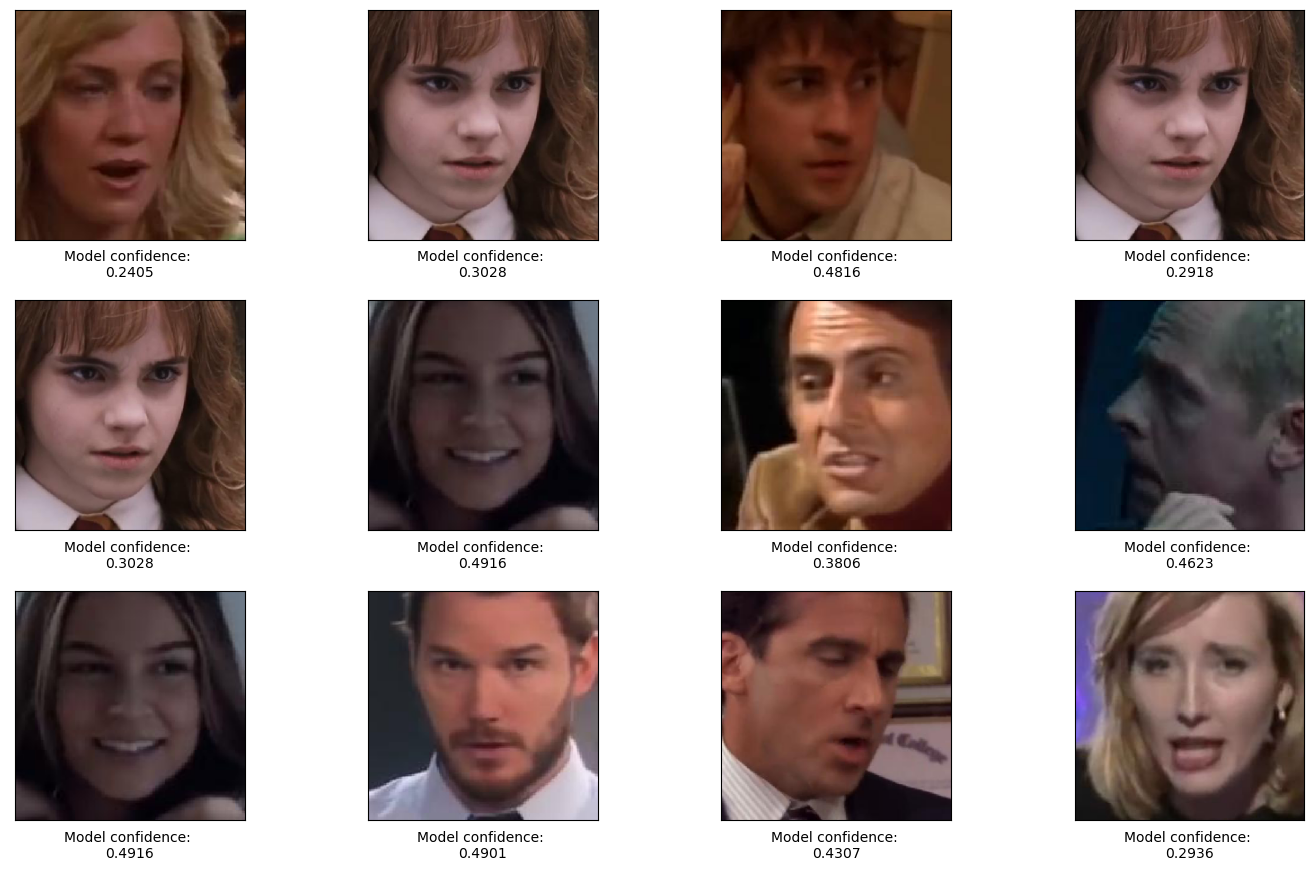

In [30]:
plotter(misclassified_real, misclassified_real_pred)

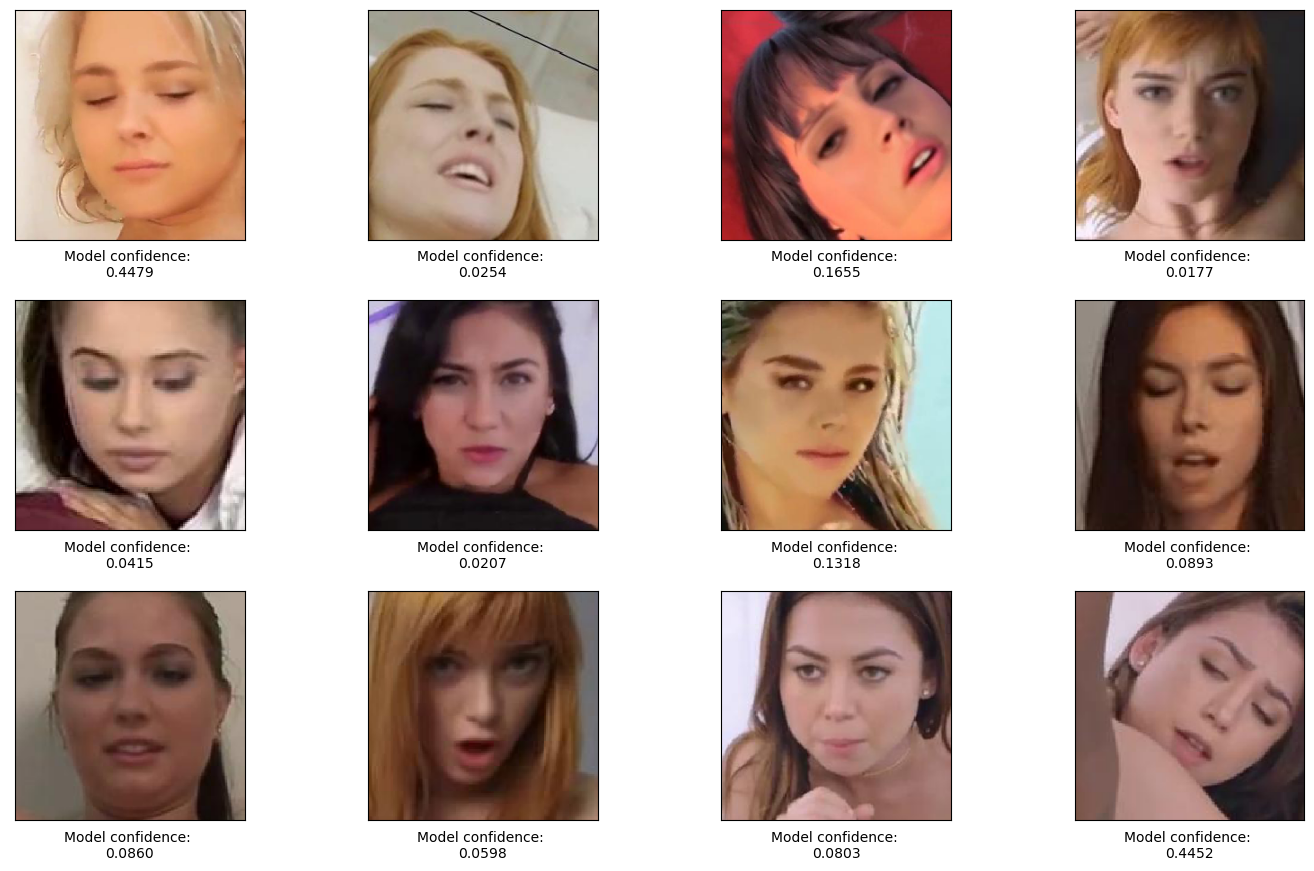

In [31]:
plotter(correct_deepfake, correct_deepfake_pred)

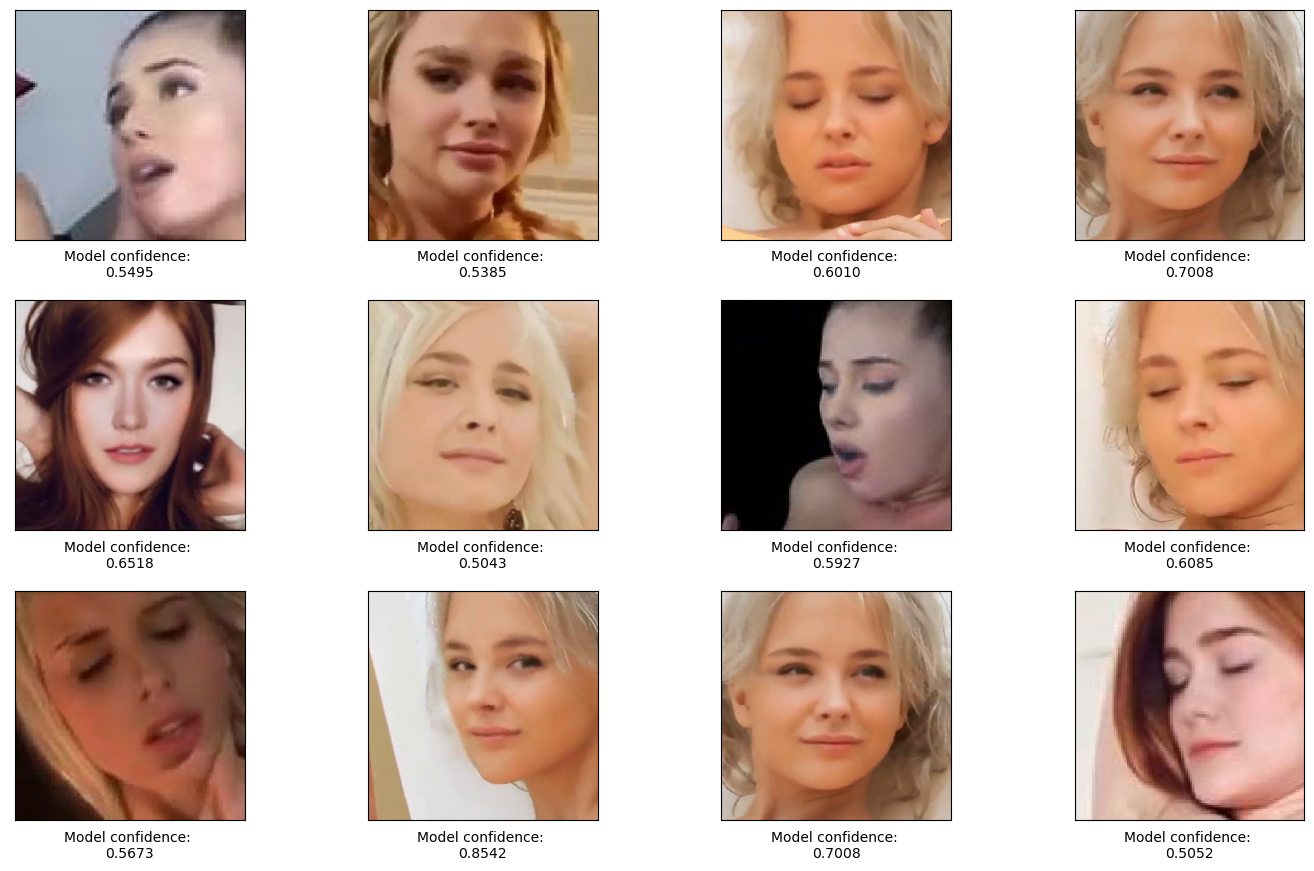

In [32]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)

## Preprocessing our dataset

In [91]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/dataset',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 1012 images belonging to 2 classes.


In [92]:
# Checking class assignment
generator.class_indices

{'fake': 0, 'real': 1}

## Making Predictions 

1/1 [==============================] - 0s 166ms/step
Predicted likelihood: 0.0815
Actual label: 0
1/1 [==============================] - 0s 171ms/step

Correct Model prediction: True


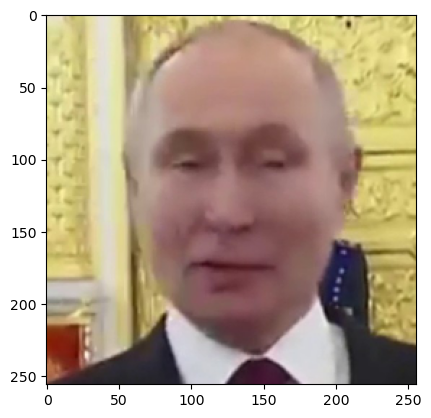

In [82]:
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect Model prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [71]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.model.predict(X, verbose=0)[0][0]  
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 100 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

0  predictions completed.
100  predictions completed.
200  predictions completed.
300  predictions completed.
400  predictions completed.
500  predictions completed.
600  predictions completed.
700  predictions completed.
800  predictions completed.
900  predictions completed.
1000  predictions completed.
All 1012 predictions completed


## Accuracy of the model on our dataset

In [57]:
# Assuming you have loaded your 'meso' model and 'generator' as defined in your code

# Evaluate the model on the entire dataset
num_samples = generator.samples
batch_size = generator.batch_size

correct_predictions = 0

# Iterate through the dataset in batches and calculate correct predictions
for _ in range(num_samples // batch_size):
    X_batch, y_batch = generator.next()
    predicted_prob = meso.model.predict(X_batch, verbose=0)[0][0]
    predicted_label = round(predicted_prob)
    actual_label = int(y_batch[0])
    correct_predictions += (predicted_label == actual_label)

# Calculate accuracy
accuracy = correct_predictions / (num_samples // batch_size)

print(f"Model Accuracy: {accuracy:.2%}")

Model Accuracy: 29.35%


In [93]:
# Creating separate lists for correctly classified and misclassified images
mine_correct_real = []
mine_correct_real_pred = []

mine_correct_deepfake = []
mine_correct_deepfake_pred = []

mine_misclassified_real = []
mine_misclassified_real_pred = []

mine_misclassified_deepfake = []
mine_misclassified_deepfake_pred = []

In [94]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.model.predict(X, verbose=0)[0][0]  
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        mine_correct_real.append(X)
        mine_correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        mine_correct_deepfake.append(X)
        mine_correct_deepfake_pred.append(pred)
    elif y[0]==1:
        mine_misclassified_real.append(X)
        mine_misclassified_real_pred.append(pred)
    else:
        mine_misclassified_deepfake.append(X)
        mine_misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 100 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")


0  predictions completed.
100  predictions completed.
200  predictions completed.
300  predictions completed.
400  predictions completed.
500  predictions completed.
600  predictions completed.
700  predictions completed.
800  predictions completed.
900  predictions completed.
1000  predictions completed.
All 1012 predictions completed


In [95]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

12


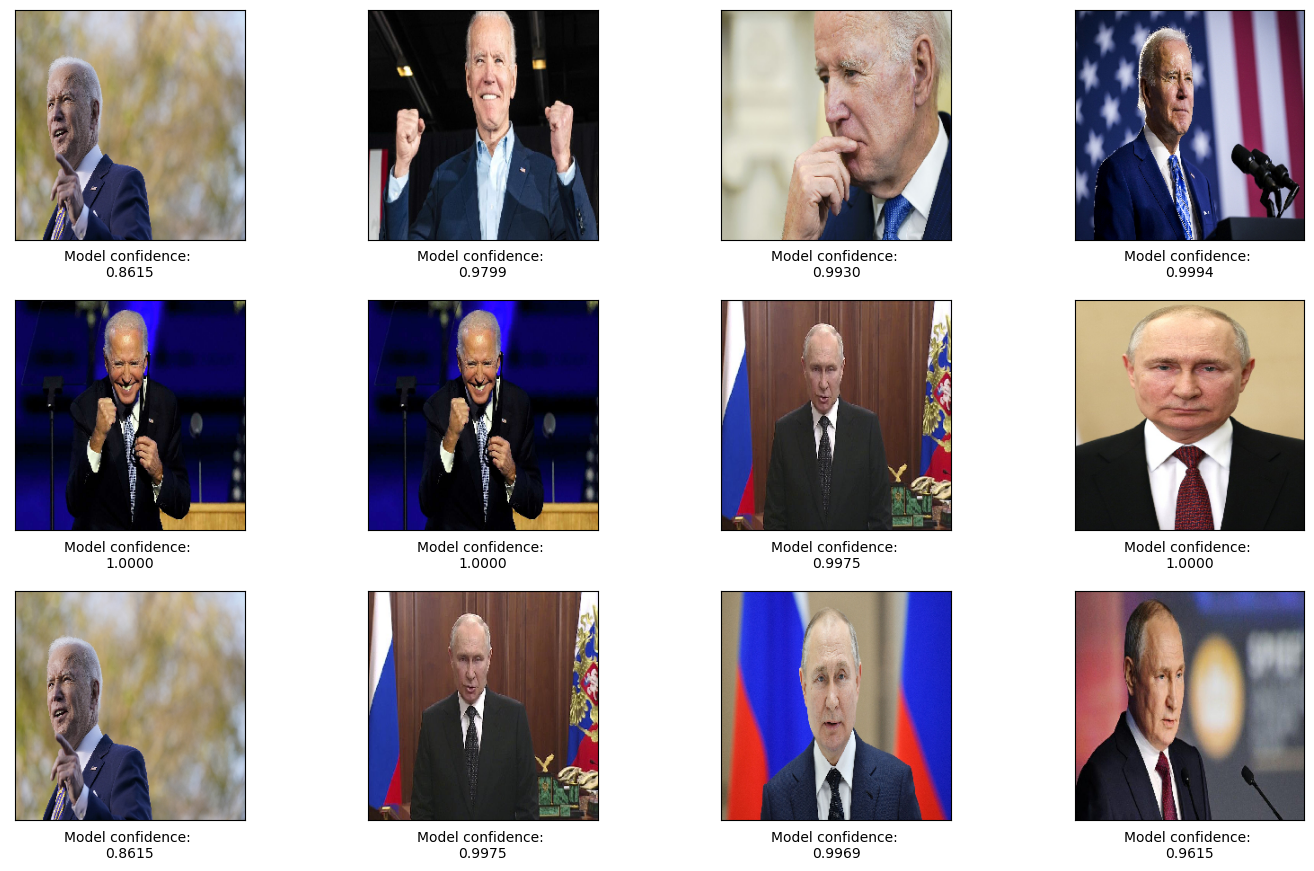

In [106]:
plotter(mine_correct_real, mine_correct_real_pred)
print(len(mine_correct_real))

In [101]:
def new_plotter(images, preds):
    if len(images) < 2:
        print("Not enough images to plot.")
        return
    
    fig = plt.figure(figsize=(16, 9))
    subset = np.random.randint(0, len(images) - 1, size=12)
    
    for i, j in enumerate(subset):
        fig.add_subplot(3, 4, i + 1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    
    plt.show()

print(len(mine_misclassified_real))
# Call the plotter function
new_plotter(mine_misclassified_real, mine_misclassified_real_pred)




0
Not enough images to plot.


286


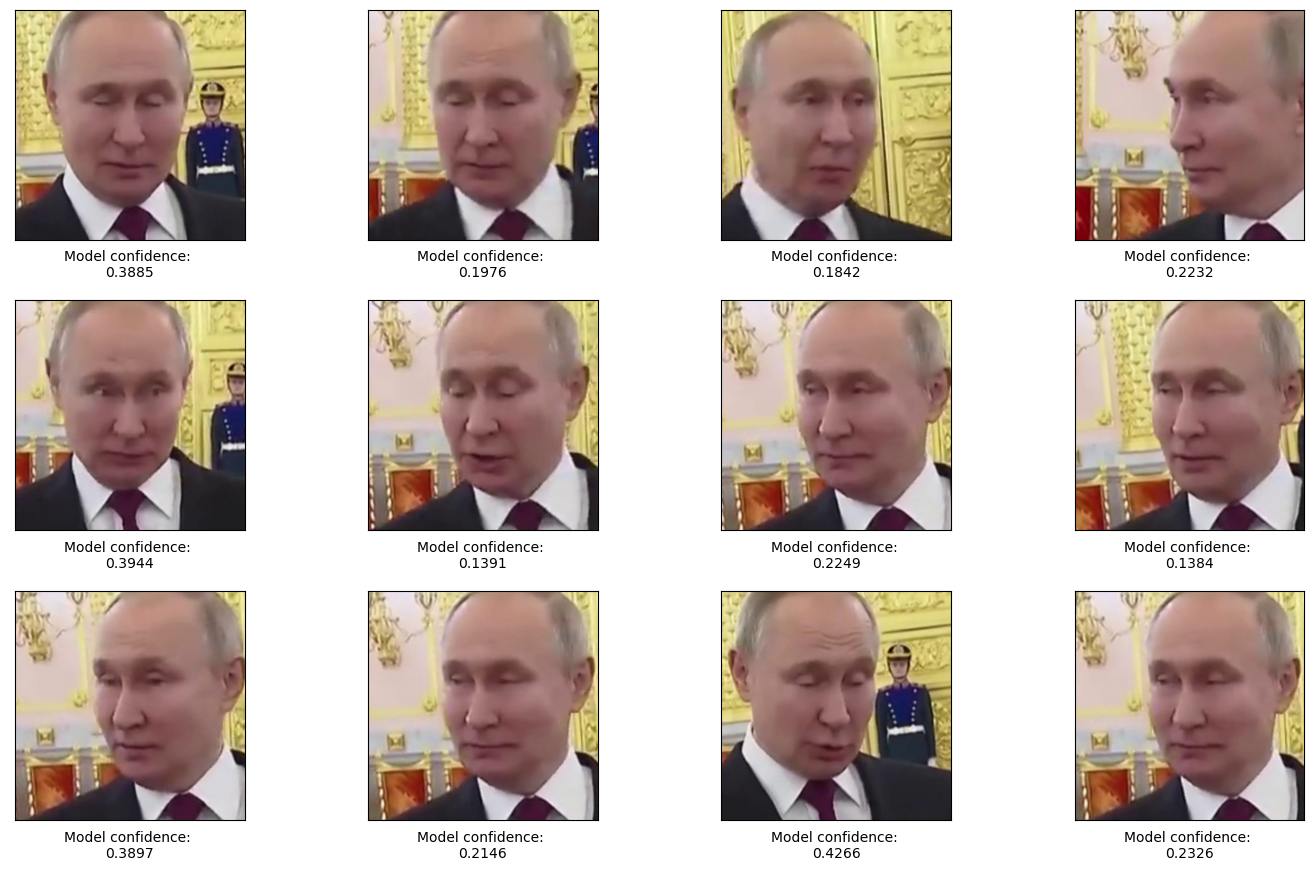

In [104]:
plotter(mine_correct_deepfake, mine_correct_deepfake_pred)
print(len(mine_correct_deepfake))

714


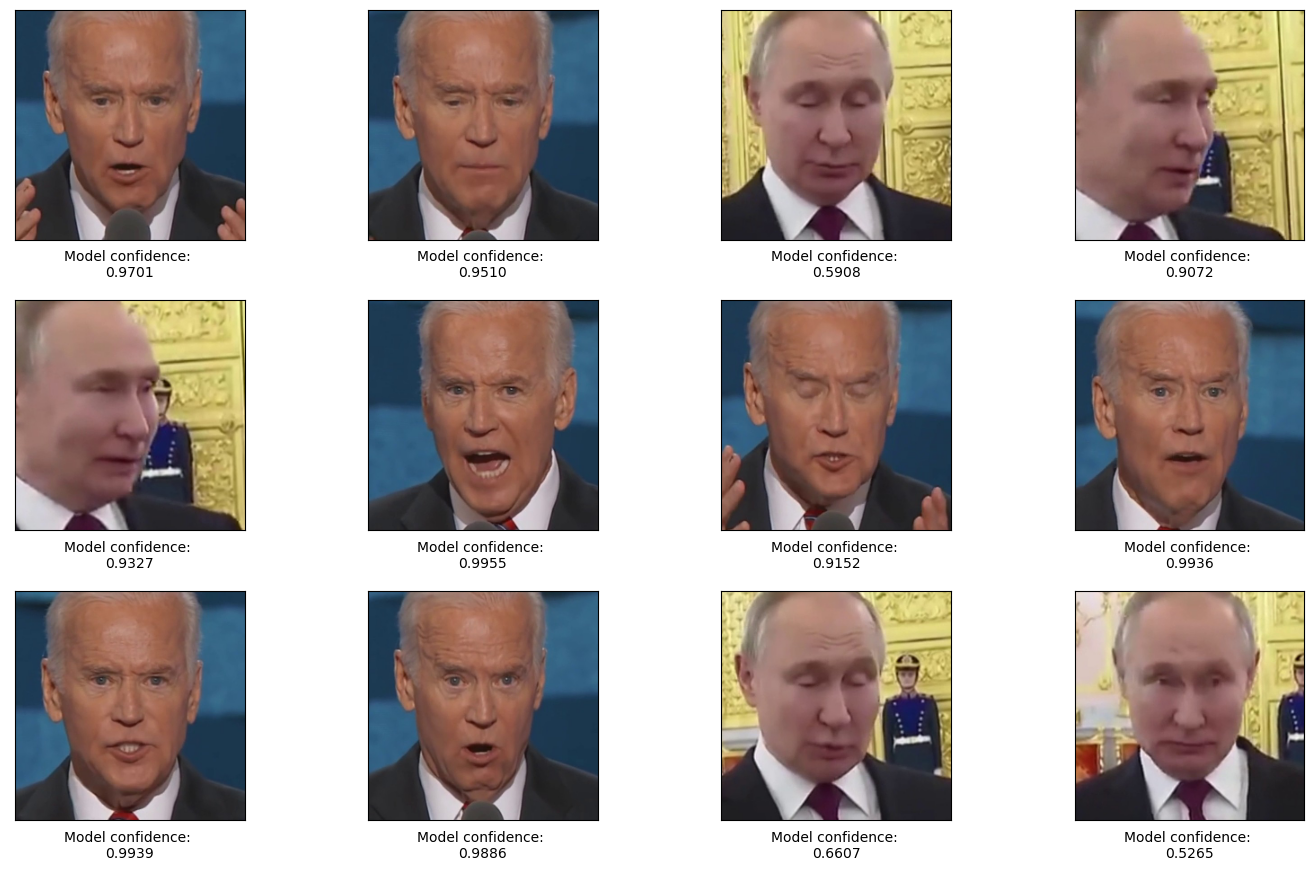

In [105]:
plotter(mine_misclassified_deepfake, mine_misclassified_deepfake_pred)
print(len(mine_misclassified_deepfake))

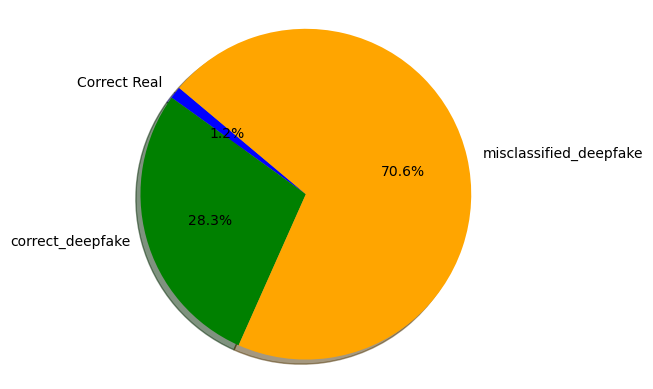

In [109]:
import matplotlib.pyplot as plt

# Example data
labels = ['Correct Real', 'correct_deepfake','misclassified_deepfake']
sizes = [len(mine_correct_real) ,len(mine_correct_deepfake),len(mine_misclassified_deepfake) ]
colors = ['blue', 'green', 'orange']

# Create the pie chart
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Display the pie chart
plt.show()
